In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/sample.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv


### This project entails sentiment prediction based on review texts provided by a reviewer. Essentially, our objective is to construct a straightforward language model capable of processing textual information and determining the sentiment conveyed within the review text.

*   ### basic libraries used in the project (alphabettically arranged)

In [2]:
# importent libraries needed for loading the data and training some base models
# basic libraries we are going to use
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score,cross_validate
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import chi2,SelectPercentile
from sklearn.metrics import f1_score,make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
import re
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.impute import SimpleImputer
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

### loading the datasets provides as pandas dataframe

In [3]:
train_data=pd.read_csv(r"/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv")
test_data=pd.read_csv(r"/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv")
movie_data=pd.read_csv(r"/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv")
submission_sample=pd.read_csv(r"/kaggle/input/sentiment-prediction-on-movie-reviews/sample.csv")

* # Data visualization and  Explanatory data anlysis(EDA)

*   ### explaining the train_data

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162758 entries, 0 to 162757
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   movieid             162758 non-null  object
 1   reviewerName        162758 non-null  object
 2   isFrequentReviewer  162758 non-null  bool  
 3   reviewText          156311 non-null  object
 4   sentiment           162758 non-null  object
dtypes: bool(1), object(4)
memory usage: 5.1+ MB


In [5]:
train_data.head(3)

,movieid,reviewerName,isFrequentReviewer,reviewText,sentiment
0,marvelous_pirate,Benjamin Henry,False,Henry Selick’s first movie since 2009’s Corali...,POSITIVE
1,tony_montana_frodo_baggins_v_rocky_balboa,Felicia Lopez,False,With a cast that reads like the Vogue Oscar pa...,NEGATIVE
2,darth_vader_katniss_everdeen_sorcerer_donnie_d...,Mr. Charles Burgess,True,Creed II does not give us anything but another...,POSITIVE


##### The training dataset comprises five columns. Initially, there is data pertaining to the movie ID associated with the given review, followed by the name of the reviewer. Subsequently, an indicator is present to signify whether the reviewer provides reviews on a frequent basis. Following this, details regarding the review text itself are included, along with the corresponding sentiment label.

* ### explaining the movies_data

In [6]:
movie_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143258 entries, 0 to 143257
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   movieid               143258 non-null  object 
 1   title                 143258 non-null  object 
 2   audienceScore         73248 non-null   float64
 3   rating                13991 non-null   object 
 4   ratingContents        13991 non-null   object 
 5   releaseDateTheaters   30773 non-null   object 
 6   releaseDateStreaming  79420 non-null   object 
 7   runtimeMinutes        129431 non-null  float64
 8   genre                 132175 non-null  object 
 9   originalLanguage      129400 non-null  object 
 10  director              143258 non-null  object 
 11  boxOffice             14743 non-null   object 
 12  distributor           23005 non-null   object 
 13  soundType             15917 non-null   object 
dtypes: float64(2), object(12)
memory usage: 15.3+ MB


In [7]:
movie_data.head(3)

,movieid,title,audienceScore,rating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,boxOffice,distributor,soundType
0,han_solo_heroic_myth_wonder_woman,Han Solo Heroic Myth Wonder Woman,50.0,NaN,NaN,NaN,2018-08-25,75.0,"Comedy, Horror, Sci-fi",English,Claude Nicolet,NaN,NaN,NaN
1,voyage_tyler_durden_han_solo_stardust,Voyage Tyler Durden Han Solo Stardust,NaN,NaN,NaN,NaN,2020-02-11,114.0,Drama,English,Nathan Haack,NaN,NaN,NaN
2,norman_bates_ferris_bueller_hermione_granger_v...,Norman Bates Ferris Bueller Hermione Granger V...,43.0,NaN,NaN,NaN,NaN,120.0,Drama,Korean,Theresa Smith,NaN,NaN,NaN


In [8]:
movie_data.columns

Index(['movieid', 'title', 'audienceScore', 'rating', 'ratingContents',
       'releaseDateTheaters', 'releaseDateStreaming', 'runtimeMinutes',
       'genre', 'originalLanguage', 'director', 'boxOffice', 'distributor',
       'soundType'],
      dtype='object')

* ##### The movies dataset comprehensively encompasses details about individual movies. It encompasses various attributes, including 'movieid,' 'title,' 'audienceScore,' 'rating,' 'ratingContents,' 'releaseDateTheaters,' 'releaseDateStreaming,' 'runtimeMinutes,' 'genre,' 'originalLanguage,' 'director,' 'boxOffice,' 'distributor,' and 'soundType.' It's notable that the primary key in this dataset is the 'movieid.'

* ##### We possess a substantial amount of movie-related information that holds potential relevance for sentiment prediction. As a result, we are keen on incorporating this dataset as part of our training data. To achieve this, we intend to merge the train data with the movies data, using the common identifier of movie ID.

* ### merging the train data and the movie data

* ##### before merging the dataset we have to remove duplicates in the movies dataset if there are any as they can result in some unncessary cross combinations.


In [9]:
sum(movie_data.duplicated())

1571

In [10]:
#  so movie data contains 1571 duplicated we can remove them
movie_data.drop_duplicates(inplace=True,keep='first')

* ##### also there can be some duplicated "movieid" to do a join we need to change the movie column in pure set.so removing the duplicated "movieid" values 

In [11]:
movie_data.drop_duplicates(subset=['movieid'],inplace=True,keep='first')

* ##### now we can join the movie data with both the train data and test data 

In [12]:
total_train_data=pd.merge(movie_data,train_data,on='movieid',how='right')
total_test_data=pd.merge(movie_data,test_data,on='movieid',how='right')

* ### explaing the total_train_data

In [13]:
total_train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162758 entries, 0 to 162757
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   movieid               162758 non-null  object 
 1   title                 162758 non-null  object 
 2   audienceScore         149510 non-null  float64
 3   rating                99034 non-null   object 
 4   ratingContents        99034 non-null   object 
 5   releaseDateTheaters   126924 non-null  object 
 6   releaseDateStreaming  146573 non-null  object 
 7   runtimeMinutes        159382 non-null  float64
 8   genre                 160320 non-null  object 
 9   originalLanguage      159468 non-null  object 
 10  director              162758 non-null  object 
 11  boxOffice             109982 non-null  object 
 12  distributor           122095 non-null  object 
 13  soundType             77391 non-null   object 
 14  reviewerName          162758 non-null  object 
 15  

* ##### The complete training dataset encompasses all the columns present in both the train data and the movie data. Within this merged dataset, there are a total of two numerical features and sixteen categorical features. It's worth noting that certain columns, such as 'box office,' offer the potential for conversion into numerical features due to their inclusion of box office collections information.also we can convert sentimant as o: as nagative and 1: as positive 

In [14]:
# defining functions for these numerical convergences:

def convert_boxoffice_value(value):
    if pd.notna(value) and value != '':
        # Convert value to string
        value = str(value)
        multiplier = 1
        if value.endswith('K'):
            multiplier = 1000
            value = value.strip('K')
        elif value.endswith('M'):
            multiplier = 1000000
            value = value.strip('M')
        # Remove dollar sign before converting to float
        value = value.replace('$', '')
        return int(float(value) * multiplier)
    return None
def numeric_change(data):
    x_train_box_office=data['boxOffice'].apply(convert_boxoffice_value)
    data['boxOffice']=x_train_box_office
    if 'sentiment' in data.columns:
        data['sentiment'].replace('POSITIVE',1,inplace=True)
        data['sentiment'].replace('NEGATIVE',0,inplace=True)
        return data
    return data

In [15]:
#after applying the function on the dataframe
clean_train_data=numeric_change(total_train_data)
clean_test_data=numeric_change(total_test_data)

* ### simple statistics of the clean_train_data(numerical features)

In [16]:
clean_train_data.describe()

,audienceScore,runtimeMinutes,boxOffice,sentiment
count,149510.000000,159382.000000,1.099820e+05,162758.000000
mean,65.214541,106.911828,4.992253e+07,0.668238
std,19.937695,22.138131,9.008999e+07,0.470848
min,0.000000,4.000000,0.000000e+00,0.000000
25%,51.000000,93.000000,1.000000e+06,0.000000
50%,68.000000,104.000000,1.490000e+07,1.000000
75%,82.000000,118.000000,5.730000e+07,1.000000
max,100.000000,561.000000,8.584000e+08,1.000000


In [17]:
# now let' use # corr() to see correlation between numerical features 
clean_train_data.corr()

/tmp/ipykernel_75/999241215.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  clean_train_data.corr()


,audienceScore,runtimeMinutes,boxOffice,isFrequentReviewer,sentiment
audienceScore,1.000000,0.259520,0.172298,-0.028060,0.313855
runtimeMinutes,0.259520,1.000000,0.338664,-0.031838,0.047960
boxOffice,0.172298,0.338664,1.000000,-0.064057,0.019945
isFrequentReviewer,-0.028060,-0.031838,-0.064057,1.000000,-0.050806
sentiment,0.313855,0.047960,0.019945,-0.050806,1.000000


* ##### The correlation matrix reveals that the only attribute strongly correlated with sentiment prediction is the 'audiencescore.' Given this observation, it would be prudent to solely incorporate the 'AudienceScore' into the model's predictions, as the correlation of other numerical features with sentiment is not as pronounced. 

/tmp/ipykernel_75/961690798.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(clean_train_data.corr(), annot=True, cmap='coolwarm', center=0)


<Axes: >

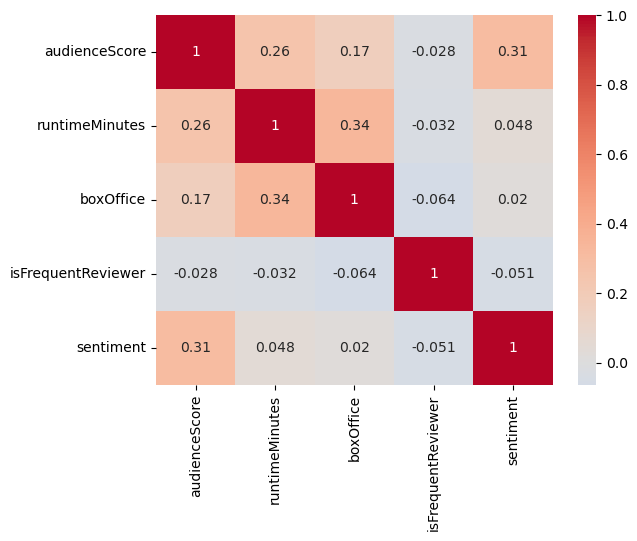

In [18]:
sns.heatmap(clean_train_data.corr(), annot=True, cmap='coolwarm', center=0)

* ##### we will take care of selected columns in the preprocessing step

* # Data preprocessing:

* ##### seperating the train data into feature dataframe(x_train) and label vector(y_train) 

In [19]:
x_train,y_train=clean_train_data.drop('sentiment',axis=1),clean_train_data['sentiment']
x_test=clean_test_data

* ##### class wights in the sentiment

<Axes: xlabel='sentiment', ylabel='Count'>

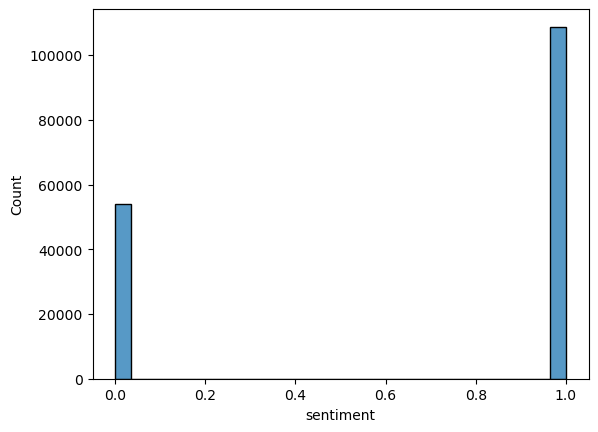

In [20]:
sns.histplot(y_train)

* ### hundling missing values

In [21]:
# missing values in x_train
x_train.isna().sum()

movieid                     0
title                       0
audienceScore           13248
rating                  63724
ratingContents          63724
releaseDateTheaters     35834
releaseDateStreaming    16185
runtimeMinutes           3376
genre                    2438
originalLanguage         3290
director                    0
boxOffice               52776
distributor             40663
soundType               85367
reviewerName                0
isFrequentReviewer          0
reviewText               6447
dtype: int64

* ##### There are missing values present in our dataset.for different type of features we can hundle missing values differently :
1. Numerical feature: for numerical feature "audience score" which is going to be used in model making we are going to use SimpleImputer with mean.
2. Categorical feature : for categorical features we can ignore missing and unknown values in encoding 
3. reviewText column: for review text column we are going to replace null values from a unique word different from other words as.I used a hindi word "khali"
##### we will apply all the steps, in pipeline for more simplicity and a robust evaluation in cross validations 

* #### cleaning the text data:

In [22]:
# observing the reviewText data
clean_train_data['reviewText'].head(50)

0     Henry Selick’s first movie since 2009’s Corali...
1     With a cast that reads like the Vogue Oscar pa...
2     Creed II does not give us anything but another...
3     I know what you're thinking, but this is no Li...
4     Director Fernando Meirelles tells the story wi...
5     "Kajillionaire" is a rich piece of storytellin...
6     A heartfelt story with a lovely performance fr...
7     If a bit long for a cartoon feature -- probabl...
8     Anchored by a charming performance from Greta ...
9     It's largely a Hanks solo show, and the belove...
10    It is not one of those family films that will ...
11    The Amazing Johnathan Documentary is ingenious...
12    A little more conflict and less beatification ...
13    13 Assassins is reliably entertaining, but ult...
14    The brown-bag movie of the year: Sneak in a bo...
15    The quirky script is packed with good lines an...
16    Small pleasures aside, the movie doesn't offer...
17    Vanderbilt tries to show us the TV news re

* ##### if we observe the text reviews they contain:-
1. null values 
2. word contractions 
3. numeric numbers 
4. spacial characters and punctuations
* ##### these are not helpful in our sentiment predictions so we can preprocess some common word contractions, and remove nueric and spacial charcters 

In [23]:
# processing contractions
import re
# Define a dictionary of some common contractions and their expansions
contraction_mapping = {
    "can't": "can not",
    "won't": "will not",
    "shouldn't": "should not",
    "aren't": "are not",
    "hadn't":"had not",
    "wasn't":"was not",
    "shouldn't":"should not"}
# Function to expand contractions
def expand_contractions(text):
    text = str(text).lower()
    words = text.split()
    expanded_words = []
    for word in words:
        if word in contraction_mapping:
            expanded_words.append(contraction_mapping[word])
        else:
            expanded_words.append(word)
    return ' '.join(expanded_words)

In [24]:
# removing spacial characters 
def clean_text(text):
    # Convert text to lowercase
    if str(text)=='nan':
        return 'khali'
    else:
        text = str(text).lower()
    # Remove special characters and punctuation
        text = re.sub(r'[^\w\s]', '', text) # for spacial characters 
        text=re.sub(r'[_0-9]', '', text) # for undercore and numeric values 
        
        return text

In [25]:
# applying these cleaning functions on both train and test dataset 
x_train['reviewText']=x_train['reviewText'].apply(expand_contractions)
x_test['reviewText']=x_test['reviewText'].apply(expand_contractions)
x_train['reviewText']=x_train['reviewText'].apply(clean_text)
x_test['reviewText']=x_test['reviewText'].apply(clean_text)

* ## Making Pipeline 

* #### we are going to make a pipeline that hundles:-
1. selecting the best columns in ColumnTransformer
2. imputation for null values 
3. encoding for the categorical columns.Here we are going to use OneHotEncoder for the categorical feature 
4. CountVectorizer for the "reviewText" column as it used word of count method for a vector representation of a sentance and appropriate for the text processing 

* #### feature selection:-
1. for feature selection on the categorical data we are going to use the SelectPerentile 
2. on text features we are also going also going to use selectPercentile 

In [29]:
# full pipeline for better integrity of the data preprocessing across the model and for better 
# model evaluations 
num_pipeline=Pipeline([('impute',SimpleImputer(strategy='mean')),
                       ('scalling',MinMaxScaler())])
cat_pipeline=Pipeline([('encoder',OneHotEncoder(handle_unknown='ignore')),
                       ('selectkbest',SelectPercentile(chi2,percentile=60))])
text_pipeline=Pipeline([('count_vec',CountVectorizer(ngram_range=(1,3),min_df=2)),
                       ('selectkbest',SelectPercentile(chi2,percentile=80))])
full_pipeline=ColumnTransformer([('num_column',num_pipeline,[2]),
                                 ('cat_column',cat_pipeline,[0,3,4,8,9,10,12,13,14]),
                                 ('text_column',text_pipeline,'reviewText')])

In [30]:
full_pipeline.fit_transform(x_train,y_train)

<162758x446030 sparse matrix of type '<class 'numpy.float64'>'
	with 6876970 stored elements in Compressed Sparse Row format>

* ## model selection:
* #### after all the experiments, these three models seems performing best on this binary classification problem:-
1. LogisticRegression 
2. Support Vector Classifier
3. Multinomial Naive Bayes

In [32]:
# models with pipelines 
lr=LogisticRegression(solver='saga',max_iter=2000,random_state=0)
lr_pipeline=Pipeline([('transformer',full_pipeline),
                       ('esti',lr)])
svc_classifier=LinearSVC(C=0.5,max_iter=2000,random_state=0)
svc_pipeline=Pipeline([('transformer',full_pipeline),
                       ('esti',svc_classifier)])
mul=MultinomialNB()
mul_pipeline=Pipeline([('transformer',full_pipeline),
                      ('esti',mul)])

* # Hyperparameter tunning:-
* we are going to use GridSearchCV for hyperparameter tunning 

* ##### For LogisticRegression

In [ ]:
# paramter grid for logistic regression
param_grid_lr={'transformer__cat_column__selectkbest__percentile':[40,50,60],
               'transformer__text_column__selectkbest__percentile':[70,80,90]}
grid_search_lr=GridSearchCV(lr_pipeline,param_grid_lr,scoring=make_scorer(f1_score,average='micro'),cv=5,n_jobs=-1)

In [ ]:
grid_search_lr.fit(x_train,y_train)

In [ ]:
# best paramter and the score by thses best paramters
print(grid_search_lr.best_params_)
print(grid_search_lr.best_score_)

In [ ]:
lr_best_estimator=grid_search_lr.best_estimator_

In [ ]:
lr_best_estimator

* ##### we can use the obtained best values of percentile for selecting the categorical features and for selecting the treansformed features form reviewText data as it is  more like best feature selection 

* #### For Support Vector Classifier

In [ ]:
# paramter grid for  Support Vector Classifier 
param_grid_svc={'transformer__cat_column__selectkbest__percentile':[60],
               'transformer__text_column__selectkbest__percentile':[90],
              'esti__C':[0.3,0.4,0.5,0.6]}
grid_search_svc=GridSearchCV(svc_pipeline,param_grid_svc,scoring=make_scorer(f1_score,average='micro'),cv=5,n_jobs=-1)

In [ ]:
grid_search_svc.fit(x_train,y_train)

In [ ]:
# best paramter and score for the support Vector Classifier 
print(grid_search_svc.best_params_)
print(grid_search_svc.best_score_)

In [ ]:
svc_best_estimator=grid_search_svc.best_estimator_

* ### For Multinomail Naive Bayes

##### for multinomial i have used MinMaxScaler as the sacalling technique for the numeric data 

In [ ]:
param_grid_nb={'transformer__cat_column__selectkbest__percentile':[60],
               'transformer__text_column__selectkbest__percentile':[60,70,80,90]}
grid_search_nb=GridSearchCV(mul_pipeline,param_grid_nb,scoring=make_scorer(f1_score,average='micro'),cv=5,n_jobs=-1)

In [ ]:
grid_search_nb.fit(x_train,y_train)

In [ ]:
print(grid_search_nb.best_params_)
print(grid_search_nb.best_score_)

In [ ]:
nb_best_estimator=grid_search_nb.best_estimator_

* # model overfitting analysis and fixing it 

In [ ]:
#def plot_learning_curves(lr, X_train, y_train, scorer, title=None, n_jobs=-1):
 #   train_sizes, train_scores, test_scores = learning_curve(
  #      estimator, X_train, y_train, cv=4, scoring=scorer, train_sizes=np.linspace(0.3, 1.0, 7), n_jobs=n_jobs)
    
  #  train_scores_mean = np.mean(train_scores, axis=1)
   # train_scores_std = np.std(train_scores, axis=1)
    #test_scores_mean = np.mean(test_scores, axis=1)
   # test_scores_std = np.std(test_scores, axis=1)
#
 #   plt.figure(figsize=(10, 6))
  #  plt.title(title if title else "Learning Curves")
  #  plt.xlabel("Training Examples")
  #  plt.ylabel(scorer.capitalize())  # Use scorer directly without capitalize()
  #  plt.grid()

 #   plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
  #                   train_scores_mean + train_scores_std, alpha=0.1, color="r")
  #  plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
  #                   test_scores_mean + test_scores_std, alpha=0.1, color="g")

  #  plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
  #           label=f"Training {scorer.capitalize()} Score")
  #  plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
  #           label=f"Cross-validation {scorer.capitalize()} Score")
#
 #   plt.legend(loc="best")
  #  plt.show()

* ### For Logistic Regression: With best parameters after gridsearchcv


In [33]:
cross_validate(lr_pipeline,x_train,y_train,cv=5,scoring=make_scorer(f1_score,average='micro'),return_train_score=True,n_jobs=-1)

{'fit_time': array([310.19535899, 242.99546695, 233.50016308, 240.38980508,
        205.08437777]),
 'score_time': array([3.35670733, 4.62102699, 4.56549549, 4.81224346, 3.41512442]),
 'test_score': array([0.83976407, 0.84203736, 0.84243672, 0.83923689, 0.84135664]),
 'train_score': array([0.9878577 , 0.98746602, 0.98801131, 0.98778867, 0.9879346 ])}

* ##### to get a more geralied error we can set high  regularization parameter that gerneralizes the model,but for me this hyperparameter setting is giving best results on the test set 

* ### For Support Vector Classifier: With best parameters after gridsearchcv

In [36]:
cross_validate(svc_pipeline,x_train,y_train,cv=5,scoring=make_scorer(f1_score,average='micro'),return_train_score=True,n_jobs=-1)

{'fit_time': array([75.55596972, 79.72673297, 75.35316753, 78.37894869, 50.86876798]),
 'score_time': array([4.98694301, 4.96938086, 4.8310101 , 4.98922825, 3.5772469 ]),
 'test_score': array([0.82461907, 0.82606291, 0.82643156, 0.82320052, 0.82430647]),
 'train_score': array([0.99457782, 0.99459318, 0.99488503, 0.99483899, 0.99473147])}

* ##### by comparing the train and validation error we can easily see the overfittig of the model

* ### For Multinomial NB: With best paramter after gridsearchcv

In [ ]:
cross_validate(nb_best_estimator,x_train,y_train,cv=5,scoring=make_scorer(f1_score,average='micro'),return_train_score=True,n_jobs=-1)

* #### this model is also overfitting the data 

* # predictions on x_test and making the submission file 

In [ ]:
test_predictions=lr_best_estimator.predict(x_test)

In [ ]:
test_predictions=test_predictions.astype(str)

In [ ]:
for i in range(len(test_predictions)):
    if float(test_predictions[i])==(1):
        test_predictions[i]='POSITIVE'
    else:
        test_predictions[i]='NEGATIVE'
id=np.arange(len(test_predictions))
my_submisson_data=zip(id,test_predictions)
submission_df=pd.DataFrame(my_submisson_data,columns=['id','sentiment'])

In [ ]:
submission_df

In [ ]:
submission_df.to_csv('submisson.csv', index=False)

* ### best scores of three models:-
1. Logistic Regression :- 0.84619
2. SVC :- 0.83971
3. Multinomial Naive Bayed:-0.79106